# Support vector machine classifier with $\ell_2$-regularization

In this example we use CVXPY to train a SVM classifier with $\ell_2$-regularization.
We are given data $(x_i,y_i)$, $i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{\pm 1\}$ are associated boolean outcomes.
Our goal is to construct a good linear classifier $\hat y = {\rm sign}(a^T x - b)$.
We find the parameters $a,b$ by minimizing the (convex) function

$$
f(a, b) =  \sum_i \left( \max\big(0, 1 - y_i (a^T x_i - b)\big) \right) + \frac{\lambda}{2} \|a\|_2
$$

The first term is the average hinge loss. The second term shrinks the coefficients in $a$ and encourages sparsity.
The scalar $\lambda \geq 0$ is a (regularization) parameter.
Minimizing $f(a,b)$  simultaneously selects features and fits the classifier.

# SVM using ADMM
We can formulate the SVM problem using ADMM as below:
$$
f(a, b) =  \sum_i \left(\sum_l \left( \max\big(0, 1 - y_l (a^T x_l - b)\big) \right) + \frac{\lambda}{2m} \|a\|_2 \right)
$$
\
Lagrangian equation with u as dual variable:

$$
L_p(a, b, z, u) =
\sum_{i=1}^m
\left(
    \frac{\lambda}{2m} \| a_i \|^2
    + \sum_j \max(0, 1 - y_j (a_i^T x_j + b_i))
\right)
+ \sum_{i=1}^m
\left(
    u_{a_i}^T (a_i - z_a)
    + u_{b_i}^T (b_i - z_b)  
+ \frac{\rho}{2} \| a_i - z_a \|^2
+ \frac{\rho}{2} \| b_i - z_b \|^2\right)
$$
\
ADMM convergence criteria
\
\
a. Primal Residual

The primal residual measures how closely the local variables  and  agree with the global variables  and It is defined as:
$$
r^{k} = \sqrt{\sum_{i=1}^m \| a_i^k - z_a^k \|_2^2 + \sum_{i=1}^m (b_i^k - z_b^k)^2}
$$

b. Dual Residual

The dual residual measures the consistency of the updates to the global variables  and It is defined as:
$$
s^k = \rho \sqrt{\sum_{i=1}^m \| z_a^k - z_a^{k-1} \|_2^2 + \sum_{i=1}^m (z_b^k - z_b^{k-1})^2}
$$

# SVM

Optimal weight vector (a): [-0.09373335  2.7881657 ]
Optimal bias (b): -6.734422531621968
Objective value: 0.3891326962404753


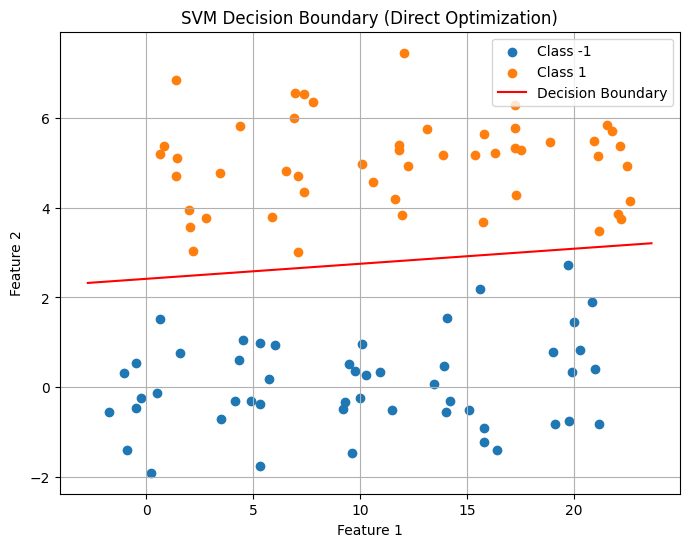

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
# Problem Parameters
np.random.seed(42)
n = 2  # Dimension of feature vectors
m = 5  # Number of nodes
points_per_node = 20
lambda_param = 0.1

# separable clusters for two labels (-1, 1)
X = []
y = []

for i in range(m):
    # Generating points for class -1
    X_class_1 = np.random.randn(points_per_node // 2, n) + np.array([i * 5, 0])
    y_class_1 = -1 * np.ones(points_per_node // 2)

    # Generating points for class +1
    X_class_2 = np.random.randn(points_per_node // 2, n) + np.array([i * 5 + 2, 5])
    y_class_2 = np.ones(points_per_node // 2)

    # Combine data for the node
    X.append(np.vstack([X_class_1, X_class_2]))
    y.append(np.hstack([y_class_1, y_class_2]))

# Combining data from all nodes into a single dataset
X_all = np.vstack(X)
y_all = np.hstack(y)

# variables for SVM
a = cp.Variable(n)  # Weight vector
b = cp.Variable()   # Bias
hinge_loss = cp.sum(cp.pos(1 - cp.multiply(y_all, X_all @ a + b)))  # Hinge loss

# objective function: Regularization + Hinge Loss
objective = cp.Minimize((lambda_param / 2) * cp.norm(a, 2)**2 + hinge_loss)

# Solving the optimization problem
problem = cp.Problem(objective)
problem.solve()

# Results
print("Optimal weight vector (a):", a.value)
print("Optimal bias (b):", b.value)
print("Objective value:", problem.value)

# Decision boundary function
def decision_boundary(x1, a, b):
    return -(a[0] * x1 + b) / a[1]

# data points
plt.figure(figsize=(8, 6))
for label in [-1, 1]:
    plt.scatter(X_all[y_all == label, 0], X_all[y_all == label, 1], label=f"Class {label}")

# decision boundary
x1_vals = np.linspace(X_all[:, 0].min() - 1, X_all[:, 0].max() + 1, 100)
x2_vals = decision_boundary(x1_vals, a.value, b.value)
plt.plot(x1_vals, x2_vals, color="red", label="Decision Boundary")

# Labels and legend
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM Decision Boundary (Direct Optimization)")
plt.legend()
plt.grid()
plt.show()

# SVM using ADMM

Global consensus weight vector (z_a): [-0.15052431  2.8438949 ]
Global consensus bias (z_b): -6.043726338557046
Objective value: 0.3891326962404753


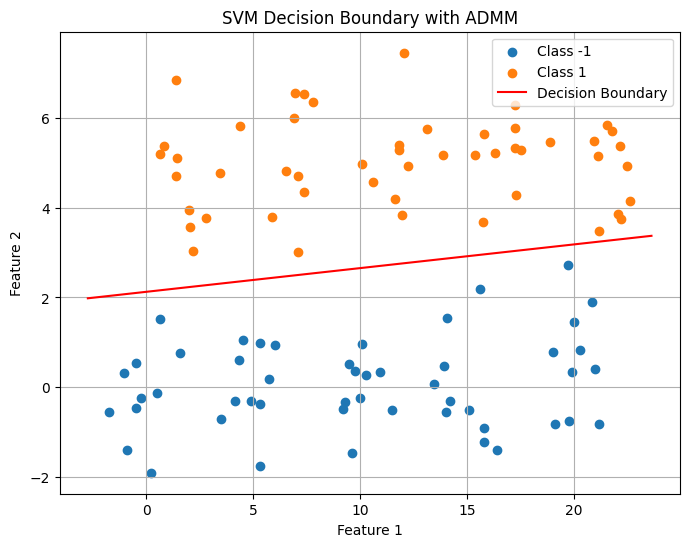

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# ADMM Parameters
rho = 0.2  # Augmented Lagrangian parameter
max_iters = 50  # Maximum number of ADMM iterations
tol = 1e-4  # Convergence tolerance

# Initializing variables
a = [cp.Variable(n) for _ in range(m)]  # Local weight vectors
b = [cp.Variable() for _ in range(m)]  # Local biases
z_a = np.zeros(n)  # Global consensus weight vector
z_a_old = z_a
z_b = 0.0  # Global consensus bias
z_b_old = z_b
u_a = [np.zeros(n) for _ in range(m)]  # Dual variables for weights
u_b = [0.0 for _ in range(m)]  # Dual variables for biases
# ADMM Iterations
for iteration in range(max_iters):
    # solvinglocal optimization problems for each node
    for i in range(m):
        hinge_loss = cp.sum(cp.pos(1 - cp.multiply(y[i], X[i] @ a[i] + b[i])))
        local_obj = (lambda_param / (2 * m)) * cp.norm(a[i], 2)**2 + hinge_loss \
                    + cp.sum(cp.multiply(u_a[i],a[i] - z_a) + cp.multiply(u_b[i],b[i] - z_b) \
                    + (rho / 2) * cp.sum_squares(a[i] - z_a) + (rho / 2) * cp.square(b[i] - z_b))
        prob = cp.Problem(cp.Minimize(local_obj))
        prob.solve()

    # updating global consensus variables
    z_a = np.mean([a[i].value + (1/rho)*u_a[i] for i in range(m)], axis=0)
    z_b = np.mean([b[i].value + (1/rho)*u_b[i] for i in range(m)])

    # updating dual variables
    for i in range(m):
        u_a[i] += rho*(a[i].value - z_a)
        u_b[i] += rho*(b[i].value - z_b)
    # checking convergence
    r_norm = np.sqrt(sum(np.linalg.norm(a[i].value - z_a)**2 + (b[i].value - z_b)**2 for i in range(m)))
    s_norm = rho * np.sqrt(sum(np.linalg.norm(z_a - z_a_old)**2 + (z_b - z_b_old)**2 for i in range(m)))
    if r_norm < tol and s_norm < tol:
        print(f"Converged in {iteration} iterations.")
        break
    z_a_old = z_a
    z_b_old = z_b
# Final Results
print("Global consensus weight vector (z_a):", z_a)
print("Global consensus bias (z_b):", z_b)
print("Objective value:", problem.value)

# a single dataset for visualization
X_all = np.vstack(X)  # Combine all features from all nodes
y_all = np.hstack(y)  # Combine all labels from all nodes

# The decision boundary; based on the global consensus weights z_a and bias z_b
def decision_boundary(x1, z_a, z_b):
    # Line equation: z_a[0] * x1 + z_a[1]  x2 + z_b = 0
    # Rearranged to solve for x2: x2 = -(z_a[0] * x1 + z_b) / z_a[1]
    return -(z_a[0] * x1 + z_b) / z_a[1]

# data points
plt.figure(figsize=(8, 6))
for label in [-1, 1]:
    plt.scatter(X_all[y_all == label, 0], X_all[y_all == label, 1], label=f"Class {label}")

# decision boundary
x1_vals = np.linspace(X_all[:, 0].min() - 1, X_all[:, 0].max() + 1, 100)
x2_vals = decision_boundary(x1_vals, z_a, z_b)
plt.plot(x1_vals, x2_vals, color="red", label="Decision Boundary")

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM Decision Boundary with ADMM")
plt.legend()
plt.grid()
plt.show()